# Notebook 1: Visualizing and exploring the data

In this notebook we visualize the data with the force layout embedding (FLE), and examine patterns and programs of gene expression in the visualization. We identify sets of cells with coherent expression patterns.

We begin by importing some useful python packages and loading the data into memory.

In [2]:
# !pip install -q wot

import ipywidgets as widgets
import pandas as pd
from matplotlib import pyplot as plt

import wot

# Path to input files
VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.loom'
FLE_COORDS_PATH ='data/fle_coords.txt'
FULL_DS_PATH = 'data/ExprMatrix.loom'
CELL_DAYS_PATH = 'data/cell_days.txt'
CELL_SETS_PATH = 'data/cell_sets.gmt'
GENE_SETS_PATH = 'data/gene_sets.gmx'

# Read expression matrix and cell days
adata = wot.io.read_dataset(FULL_DS_PATH, obs=[CELL_DAYS_PATH, FLE_COORDS_PATH])
unique_days = adata.obs['day'].unique()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Visualizing the data with the force layout embedding

The FLE is a graph visualization tool which we apply to layout a nearest neighbor graph constructed from our single cell gene expression data. There is a node for each cell, and each cell is connected to its k nearest neighbors. Then the cells are arranged in 2D so that cells connected by an edge attract, and cells not connected by an edge repel each other. This visualization is used many times throughout the tutorial.

The following code block computes a 2d visualization of the expression profiles, and then loads the resulting 2d coordinates into memory. In our paper, we used Gephi to interactively compute the FLE. Since then, we have modified the Gephi source code. 

Text(0.5, 1.0, 'Day')

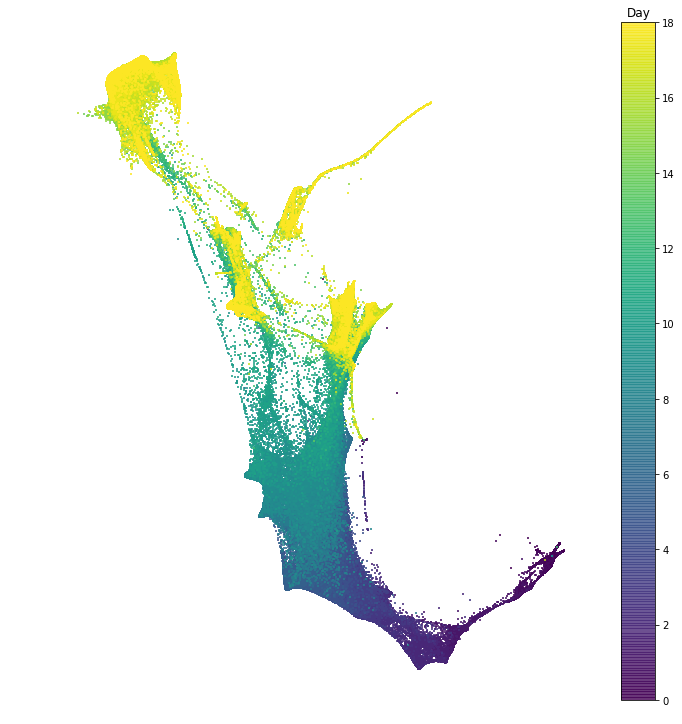

In [4]:
### compute neighborhood graph and save in gexf format for running force atlas
#adata = wot.io.read_dataset(VAR_GENE_DS_PATH)
#wot.neighborhood_graph.compute_neighborhood_graph(adata, space='dmap', neighbors=50, pca_comps=100, diff_comps=20)
#wot.neighborhood_graph.graph_to_gexf(adata, 'fle-input.gexf')

### download and run force atlas
#!wget https://github.com/klarman-cell-observatory/forceatlas2/releases/download/1.0.3/forceatlas2.jar
#!wget https://github.com/klarman-cell-observatory/forceatlas2/releases/download/1.0.3/gephi-toolkit-0.9.2-all.jar
#!java -cp forceatlas2.jar:gephi-toolkit-0.9.2-all.jar kco.forceatlas2.Main --input fle-input.gexf --output fle_coords --2d --seed 1234 --nsteps 1000

### examine convergence of force atlas
#coords_df = pd.read_csv('fle_coords.txt', sep='\t', index_col=0)
#convergence_df = pd.read_csv('fle_coords.distances.txt', sep='\t')
#convergence_df.plot(x='step', y='distance', figsize=(10, 5))
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
plt.scatter(adata.obs['x'], adata.obs['y'],c=adata.obs['day'],
               s=4, marker=',', edgecolors='none', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_title('Day')

# Compute gene signature scores

We next score each cell according to its expression of various gene signatures. To do this, we test whether the set of genes in a signature is significantly expressed in each cell. 

In [ ]:
gs = wot.io.read_sets(GENE_SETS_PATH, adata.var.index.values)
gene_set_scores_df = pd.DataFrame(index=adata.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=adata, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    gene_set_scores_df[gene_set_name] =result['score']
gene_set_scores_df.to_csv('data/gene_set_scores.csv')


We can then visualize these scores on the FLE coordinates.

In [ ]:
gene_set_scores_df = pd.read_csv('data/gene_set_scores.csv',index_column = 0)
gene_set_scores_df = gene_set_scores_df.join(coord_df).join(days_df)


gene_set_dropdown = widgets.Dropdown(
    options=gene_set_scores_df.columns,
    description='Gene Set:'
)

day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_gene_set_vis(name, days):
    gene_set_score_coords = gene_set_scores_df[(gene_set_scores_df[day_obs_name]>=days[0]) & (gene_set_scores_df[day_obs_name]<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(gene_set_score_coords['x'], gene_set_score_coords['y'], c=gene_set_score_coords[name],
                   s=4, marker=',', edgecolors='none')
    cb = plt.colorbar()
    cb.ax.set_title('Signature')
    figure2 = plt.figure(figsize=(10, 5))
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.hist(gene_set_score_coords[name])
    return figure, figure2

widgets.interact(update_gene_set_vis, name=gene_set_dropdown, days=day_selector)

# Cell Sets

We next define sets of cells with coherent expression patterns. In the following notebooks, we will use optimal transport to examine the developmental trajectories leading to these cell sets.

In [3]:
### Load cell sets
cell_sets = wot.io.read_sets(CELL_SETS_PATH)

### Visualize Cell Sets 
cell_set_dropdown = widgets.Dropdown(
    options=cell_sets.var.index,
    description='Cell Set:'
)

day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_cell_set_vis(name, days):
    cell_set = cell_sets[:, name]
    cell_set_coords = cell_set[cell_set.X>0].obs.join(coord_df).join(days_df)
    cell_set_coords = cell_set_coords[(cell_set_coords[day_obs_name]>=days[0]) & (cell_set_coords[day_obs_name]<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}, {:,} cells'.format(days[0], days[1], cell_set_coords.shape[0]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(cell_set_coords['x'], cell_set_coords['y'], c=cell_set_coords[day_obs_name],
                   s=4, marker=',', edgecolors='none', vmin=unique_days[0],  vmax=unique_days[len(unique_days)-1])
    cb = plt.colorbar()
    cb.ax.set_title('Day')

widgets.interact(update_cell_set_vis, name=cell_set_dropdown, days=day_selector)

TraitError: Invalid selection: value not found